In [18]:
import function as f

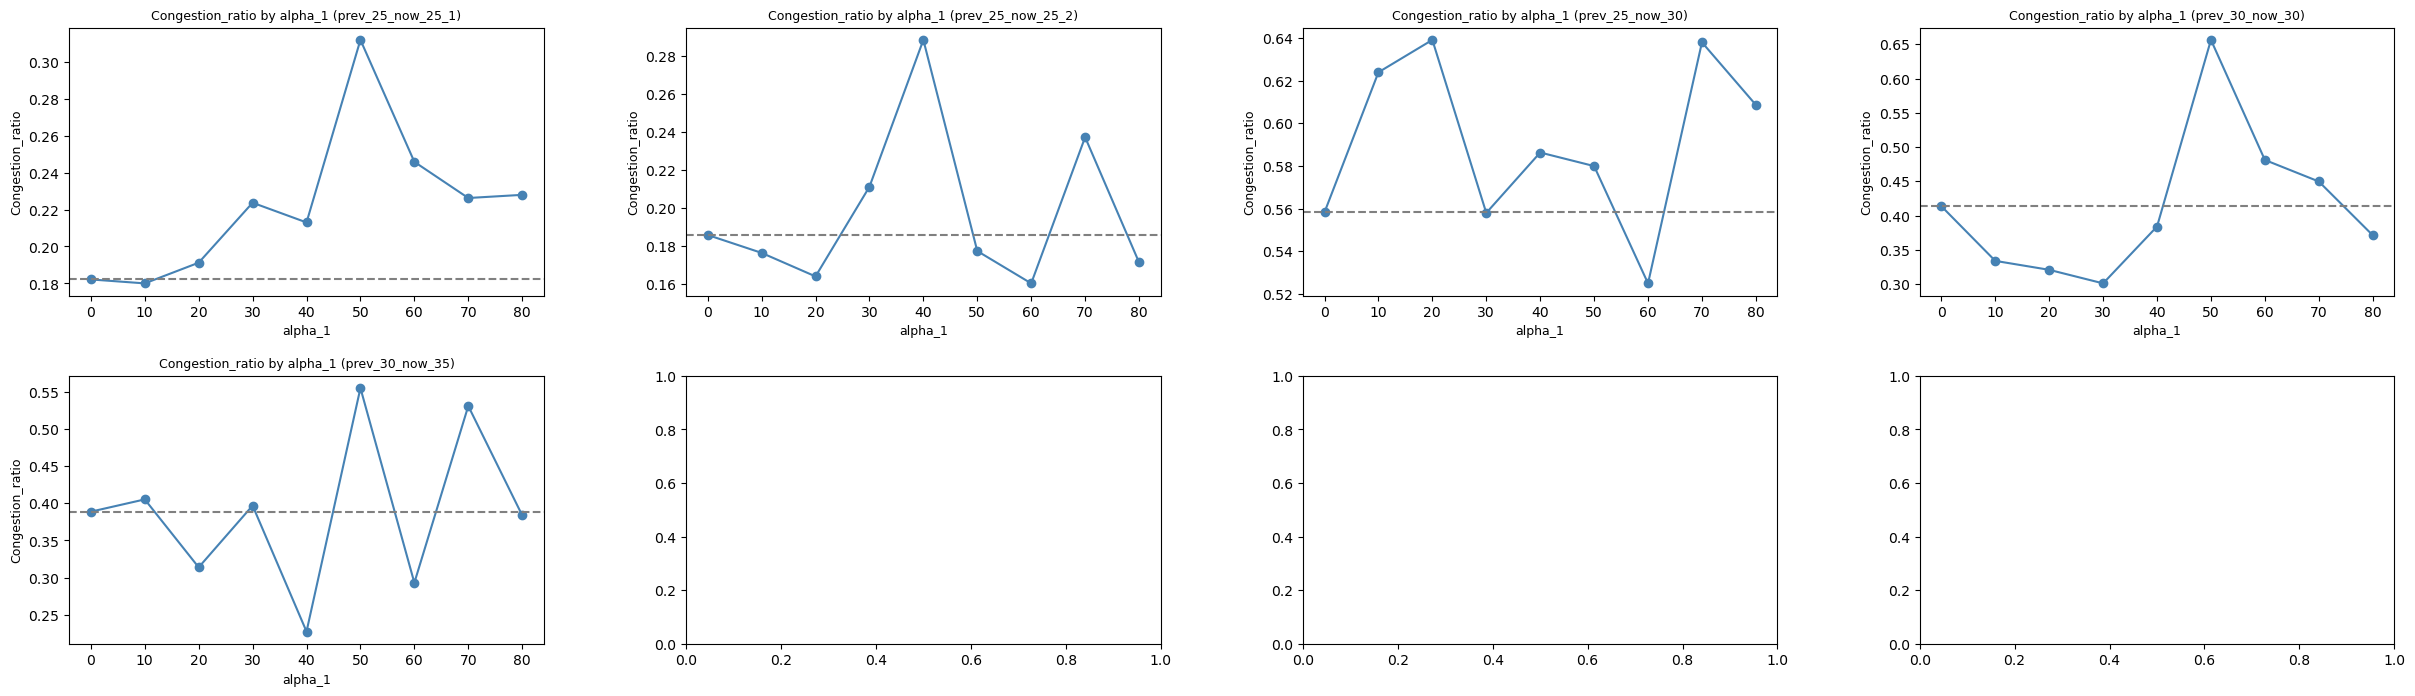

In [19]:
directory_path = '../Simulation/Assets/Results/Congestion'
x_label = 'alpha_1'
y_label = 'Congestion_ratio'
title = 'Congestion_ratio by alpha_1'
row_num = 2
col_num = 4
f.Create_subplot_congestion(directory_path, x_label, y_label, title, row_num, col_num, (30, 8))

In [89]:
import matplotlib.pyplot as plt
import os
import re
import pandas as pd

def get_congestion_ratio_df(_folder_path):

    wt_df, wot_df = f.create_congestion_df(_folder_path)
    # Perform the subtraction and division
    merged_df = wt_df.merge(wot_df, on=['Prev Truck Number', 'Now Truck Number', 'alpha_1', 'repeat_num', 'alpha_2', 'alpha_3', 'Truck_id'], suffixes=('_wt', '_wot'))
    merged_df['Pickup_Congestion_ratio'] = (merged_df['PickupSta AT_wt'] - merged_df['PickupSta AT_wot'])/merged_df['PickupSta AT_wot']
    merged_df['Drop_Congestion_ratio'] = (merged_df['DropSta AT_wt'] - merged_df['DropSta AT_wot'])/merged_df['DropSta AT_wot']
    # alpha값들에 따라서 그룹화를 한후 Pickup_Congestion_ratio, Drop_Congestion_ratio의 전체 평균을 구한다.
    merged_df_congestion_ratio = merged_df.groupby(['alpha_1', 'alpha_2', 'alpha_3'])[['Pickup_Congestion_ratio', 'Drop_Congestion_ratio']].mean()

    # index to column
    merged_df_congestion_ratio = merged_df_congestion_ratio.reset_index()

    # 각 행별로 평균 구하기
    merged_df_congestion_ratio['Congestion_ratio'] = (merged_df_congestion_ratio['Pickup_Congestion_ratio'] + merged_df_congestion_ratio['Drop_Congestion_ratio'])/2
    # drop unnecessary columns
    merged_df_congestion_ratio = merged_df_congestion_ratio.drop(['Pickup_Congestion_ratio', 'Drop_Congestion_ratio'], axis=1)
    return merged_df_congestion_ratio

def group_folders_by_truck_numbers(_directory_path):
    folder_groups = {}
    
    for folder_name in os.listdir(_directory_path):
        
        # 확장자 얻기
        extension = os.path.splitext(folder_name)[-1]

        # .csv 파일만 가져오기
        if extension != '.meta':
            folder_path = os.path.join(_directory_path, folder_name)

            # list to tuple
            key = tuple(map(int, re.findall("\d+", folder_name)[:2]))
            congestion_df = get_congestion_ratio_df(folder_path)
            if key in folder_groups:
                folder_groups[key].append(congestion_df)
            else:
                
                folder_groups[key] = [congestion_df]
    
    return folder_groups

def subplot_congestion_avg(_directory_path, _x_label, _y_label, _title, row_num, col_num, fig_size):
    
    
    f, axes = plt.subplots(row_num, col_num)
    
    # 격자 크기 설정
    f.set_size_inches(fig_size)

    # 격자 여백 설정
    plt.subplots_adjust(wspace = 0.3, hspace = 0.3)
    
    row_index = 0
    col_index = 0
    
    grouped_data = group_folders_by_truck_numbers(_directory_path)
    
    for i in range(len(grouped_data)):
        # get first key
        key = list(grouped_data.keys())[i]
        # 행별로 각 데이터프레임의 Congestion_ratio 열의 합계를 초기화
        sum_congestion = pd.Series(0.0, index=grouped_data[key][0].index)

        # 데이터프레임 리스트를 순회하면서 행별로 Congestion_ratio 열을 합산
        for df in grouped_data[key]:
    
            sum_congestion += df['Congestion_ratio']
            
        # 데이터프레임의 개수로 나누어 각 행별 평균을 계산
        average_congestion = sum_congestion / len(grouped_data[key])     

        # 결과를 새로운 데이터프레임으로 생성
        result_df = pd.DataFrame({'alpha_1' : df['alpha_1'].values, 'alpha_2' : df['alpha_2'].values, 'alpha_3' : df['alpha_3'].values, 
                                        'Congestion_ratio_mean': average_congestion})
        
        x_value_1 = result_df[i]["alpha_1"]
        y_value_1 = result_df[i]['Congestion_ratio_mean']
        
        if row_num == 1:
            plt.subplot(1, col_num, col_index + 1)
            plt.plot(x_value_1, y_value_1 , marker='o', linestyle='-', color = 'steelblue')

            plt.xlabel(_x_label, fontsize=9, ha='center')
            plt.ylabel(_y_label, fontsize=9)
            # x축 10 단위로 표시
            # plt.xticks(range(x_value_1.min(), x_value_1.max() + 10, 10))
            plt.title(_title + ' (prev_' + key[0] + '_now_' + key[1] +')', fontsize=9, ha='center')
            plt.axhline(y=y_value_1.iloc[0], color='gray', linestyle='--')
            
        else:
            # x축 10 단위로 표시
            # axes[row_index, col_index].set_xticks(range(x_value_1.min(), x_value_1.max() + 10, 10))
            axes[row_index, col_index].plot(x_value_1, y_value_1 , marker='o', linestyle='-', color = 'steelblue')
            axes[row_index, col_index].axhline(y=y_value_1.iloc[0], color='gray', linestyle='--')
            
            # title_name = "Completion Time by alpha_1 (prev_20_now_20)"
            title_name = _title +  ' (prev_' + key[0] + '_now_' + key[1] +')'
            
            axes[row_index, col_index].set_xlabel(_x_label, fontsize=9, ha='center')
            axes[row_index, col_index].set_ylabel(_y_label, fontsize=9)
            axes[row_index, col_index].set_title(title_name, fontsize=9, ha='center')

        col_index += 1
        if(col_index == col_num):
            col_index = 0
            row_index += 1
        
    plt.show()

KeyError: 0

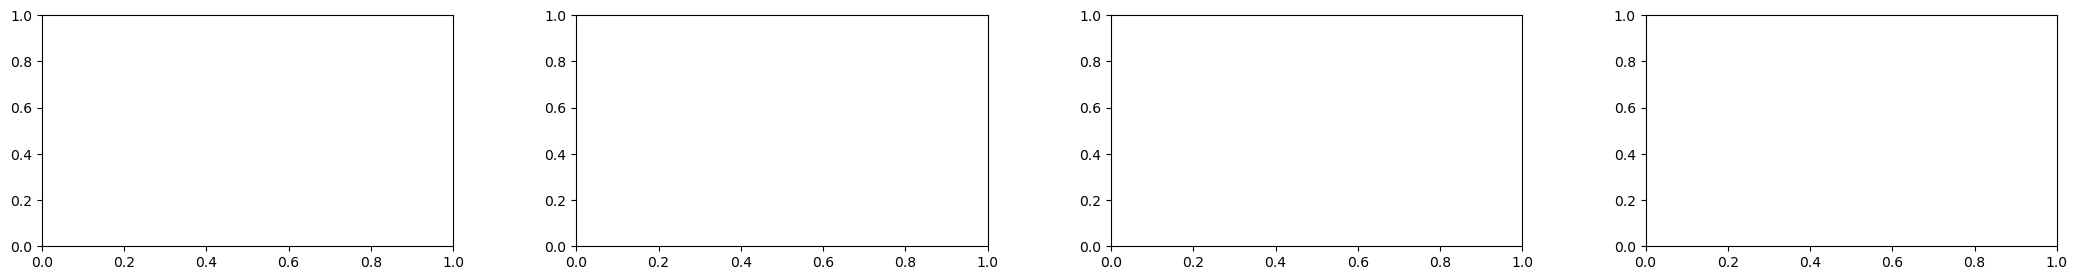

In [90]:
directory_path = '../Simulation/Assets/Results/Congestion'
x_label = 'alpha_1'
y_label = 'Congestion_ratio'
title = 'Congestion_ratio by alpha_1'
row_num = 1
col_num = 4
subplot_congestion_avg(directory_path, x_label, y_label, title, row_num, col_num, (26, 3))